I trained the model on Kaggle

https://www.kaggle.com/code/yutong0807/img-classification-with-tf-resnet50/notebook

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import os.path as path
import cv2
import numpy as np

## Load Data

In [2]:
import random
def knuthShuffle(list1, list2):
    for (i, e) in enumerate(list1):
        j = random.randint(0, i)
        if i != j:
            list1[i], list1[j] = list1[j], list1[i]
            list2[i], list2[j] = list2[j], list2[i]

In [3]:
def loadData(folder, shuffle=False):
    catFolder = path.join(folder, 'Cat/')
    dogFolder = path.join(folder, 'Dog/')

    catsPath = [path.join(catFolder, f) for f in os.listdir(catFolder) if path.isfile(path.join(catFolder, f))]
    dogsPath = [path.join(dogFolder, f) for f in os.listdir(dogFolder) if path.isfile(path.join(dogFolder, f))]

    cats = []
    dogs = []
    for cat in catsPath:
        cat = cv2.imdecode(np.fromfile(cat, dtype=np.uint8), 1)
        if cat is not None:
            cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
            cat = cv2.resize(cat, (224, 224))
            cats.append(cat)
    
    for dog in dogsPath:
        dog = cv2.imdecode(np.fromfile(dog, dtype=np.uint8), 1)
        if dog is not None:
            dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
            dog = cv2.resize(dog, (224, 224))
            dogs.append(dog)
    x = cats+dogs
    y = [0]*len(cats) + [1]*len(dogs)
    
    if shuffle:
        knuthShuffle(x, y)
        
    return np.array(x), np.array(y, dtype=np.int8)

In [4]:
x_train, y_train = loadData('/kaggle/input/picture-of-cats-and-dogs/training_dataset', shuffle=True)
x_test, y_test = loadData('/kaggle/input/picture-of-cats-and-dogs/validation_dataset')

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(16165, 224, 224, 3) (16165,)
(1797, 224, 224, 3) (1797,)


## Load Model

In [6]:
import gc
gc.collect()

119

In [7]:
model = tf.keras.Sequential()
resnet = tf.keras.applications.resnet50.ResNet50(include_top = False, input_shape=(224,224,3), weights='imagenet')
model.add(resnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

2022-12-02 04:25:17.132956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 04:25:17.234902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 04:25:17.235755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 04:25:17.236823: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
model1 = model
model2 = tf.keras.models.clone_model(model1)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [9]:
# early stop
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## Train Model 1

In [10]:
model1.compile(optimizer='adam',loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=.4, gamma=1.0), metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=16, callbacks=[earlyStop])

2022-12-02 04:25:23.033236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2433285120 exceeds 10% of free system memory.
2022-12-02 04:25:25.792426: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2433285120 exceeds 10% of free system memory.
2022-12-02 04:25:27.760469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-02 04:25:33.869689: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1011/1011 [==============================] - 116s 103ms/step - loss: 0.1763 - accuracy: 0.6364 - val_loss: 0.1824 - val_accuracy: 0.6466
Epoch 2/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.1520 - accuracy: 0.6220 - val_loss: 0.1503 - val_accuracy: 0.6622
Epoch 3/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.1528 - accuracy: 0.6474 - val_loss: 1.7179 - val_accuracy: 0.4769
Epoch 4/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.1407 - accuracy: 0.6763 - val_loss: 0.1829 - val_accuracy: 0.5320
Epoch 5/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.1352 - accuracy: 0.7049 - val_loss: 1.5424 - val_accuracy: 0.3372
Epoch 6/100
1011/1011 [==============================] - 103s 101ms/step - loss: 0.1236 - accuracy: 0.7538 - val_loss: 0.1282 - val_accuracy: 0.7563
Epoch 7/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.1034 - accuracy: 0.8150 - val_loss:

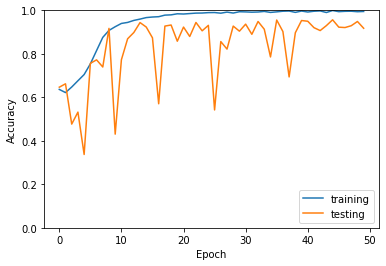

In [11]:
plt.plot(history1.history['accuracy'], label='training')
plt.plot(history1.history['val_accuracy'], label = 'testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
model1.save("resnet50-SigmoidFocalCrossEntropy")

2022-12-02 05:52:11.486376: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Train Model 2

In [13]:
model2.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=16, callbacks=[earlyStop])

2022-12-02 05:52:35.927942: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2433285120 exceeds 10% of free system memory.
2022-12-02 05:52:38.552292: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2433285120 exceeds 10% of free system memory.


Epoch 1/100
1011/1011 [==============================] - 110s 103ms/step - loss: 0.6637 - accuracy: 0.6528 - val_loss: 0.6779 - val_accuracy: 0.5242
Epoch 2/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.6121 - accuracy: 0.6669 - val_loss: 6.4499 - val_accuracy: 0.4919
Epoch 3/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.6189 - accuracy: 0.6616 - val_loss: 0.6189 - val_accuracy: 0.6761
Epoch 4/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.5969 - accuracy: 0.6727 - val_loss: 2.1418 - val_accuracy: 0.5019
Epoch 5/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.5911 - accuracy: 0.6819 - val_loss: 0.6265 - val_accuracy: 0.6850
Epoch 6/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.5816 - accuracy: 0.6888 - val_loss: 0.6709 - val_accuracy: 0.6505
Epoch 7/100
1011/1011 [==============================] - 103s 102ms/step - loss: 0.5429 - accuracy: 0.7172

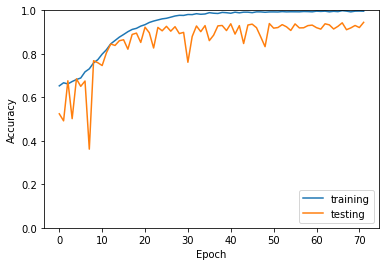

In [14]:
plt.plot(history2.history['accuracy'], label='training')
plt.plot(history2.history['val_accuracy'], label = 'testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [15]:
model2.save("resnet50-BinaryCrossEntrop")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
